In [2]:
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import community
import scipy.io
import math
import re
import os
import pickle

In [ ]:
import networkx as nx
import math

G = nx.Graph()

triangle_areas = []

for triangle in nx.enumerate_all_cliques(G, size=3):
    if len(triangle) == 3:
        a, b, c = triangle
        if (G[a][b]['weight'] + G[b][c]['weight'] > G[a][c]['weight'] and
            G[b][c]['weight'] + G[a][c]['weight'] > G[a][b]['weight'] and
            G[a][c]['weight'] + G[a][b]['weight'] > G[b][c]['weight']):

            s = (G[a][b]['weight'] + G[b][c]['weight'] + G[a][c]['weight']) / 2
            area = math.sqrt(s * (s - G[a][b]['weight']) * (s - G[b][c]['weight']) * (s - G[a][c]['weight']))
            triangle_areas.append(area)

print(triangle_areas)


In [3]:
def filter_strings_not_in_list(strings_list, substrings_list):
    filtered_list = []
    for s in strings_list:
        if not any(substring in s for substring in substrings_list):
            filtered_list.append(s)
    return filtered_list
folder_path = '/path_to/ROISignals_FunImgARCWF'  
strings_list = []
for i, file_name in enumerate(os.listdir(folder_path)):
    if i % 2 == 0:
        strings_list.append(file_name)
    
with open('/path_to/first_id_list.pkl', 'rb') as file:
    data_list_substrings = pickle.load(file)

filtered_list = filter_strings_not_in_list(strings_list, data_list_substrings)
print("----Loading Filenames Done")

----Loading Filenames Done


In [ ]:
G_dic = {}

for k, file_name in enumerate(filtered_list[:1300]):
    pattern = r"S\d+"
    match = re.search(pattern, file_name)
    s_part = match.group()[1:]
    t_wind = 0
    end_t = 0
    
    if int(s_part) != 16:
        if int(s_part) != 25:
            mat = scipy.io.loadmat(os.path.join(folder_path, file_name))
            matrix = mat['ROISignals']

            aal_array = matrix[:, :116]  # 1~116: Automated Anatomical Labeling (AAL) atlas (Tzourio-Mazoyer et al., 2002)
            #hoac_array = matrix[:, 116:212]   # 117~212: Harvard-Oxford atlas (Kennedy et al., 1998)– cortical areas
            #hoas_array = matrix[:, 212:228]   # 213~228: Harvard-Oxford atlas (Kennedy et al., 1998)– subcortical areas
            #ccl_array = matrix[:, 228:428]    # 229~428: Craddock’s clustering 200 ROIs (Craddock et al., 2012)
            #zrp_array = matrix[:, 428:1408]   # 429~1408: Zalesky’s random parcelations (compact version: 980 ROIs) (Zalesky et al., 2010)
            #dbf_array = matrix[:, 1408:1568]  # 1409~1568: Dosenbach’s 160 functional ROIs (Dosenbach et al., 2010)

            correlation_measure = ConnectivityMeasure(kind='correlation')
            correlation_matrix = correlation_measure.fit_transform([aal_array])[0]

            # Define threshold
            threshold = 0.35  
            thresholded_matrix = np.where(correlation_matrix < threshold, 0, correlation_matrix)
            np.fill_diagonal(thresholded_matrix, 0)

            graph = nx.Graph()  
            num_nodes = thresholded_matrix.shape[0]
            graph.add_nodes_from(range(num_nodes))

            for i in range(num_nodes):
                for j in range(num_nodes):
                    weight = thresholded_matrix[i][j]
                    if weight != 0:
                        graph.add_edge(i, j, weight=weight)

            G_dic[file_name] = graph
            #print(k)

In [ ]:
labels = []
features_list = []
for i, (file_name, G) in enumerate(G_dic.items()):  
    triangle_areas = []
    # iterate over triangle
    for a in G.nodes():
        for b in G.nodes():
            if b<a:
                for c in G.nodes():
                    if c<b:
                        try:
                            if (G[a][b]['weight'] + G[b][c]['weight'] > G[a][c]['weight'] and
                                G[b][c]['weight'] + G[a][c]['weight'] > G[a][b]['weight'] and
                                G[a][c]['weight'] + G[a][b]['weight'] > G[b][c]['weight']):
                                
                                # Heronsche Formula
                                s = (G[a][b]['weight'] + G[b][c]['weight'] + G[a][c]['weight']) / 2
                                area = math.sqrt(s * (s - G[a][b]['weight']) * (s - G[b][c]['weight']) * (s - G[a][c]['weight']))
                                #print('DOES WORK 1')
                            else:
                                area = 0
                                #print('DOES WORK 0')
                        except:
                            #print('does not work')
                            area = 0
                        triangle_areas.append(area)
    #print(f'----{i+1} Done!') 
    features_list.append(np.array(triangle_areas))
    labels.append(int(file_name.split('-')[1]))
X = np.array(features_list)
y = np.array(labels)

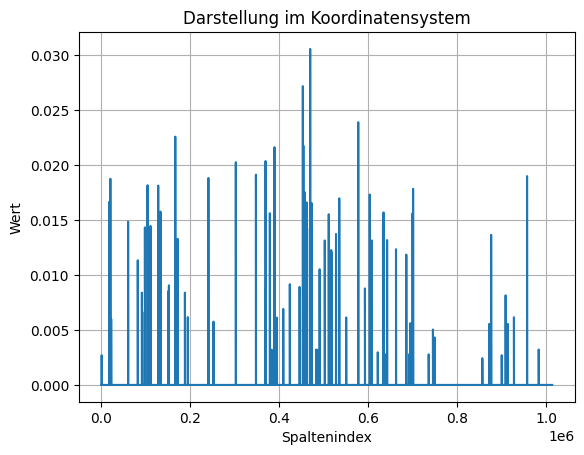

In [55]:
# packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X)
tree = DecisionTreeClassifier()
#tree_two = DecisionTreeClassifier()
tree.fit(X, y)
#tree_two.fit(X_scaled, y)

# Gini Importance Score
importance = tree.feature_importances_
#importance_two = tree_two.feature_importances_
data = importance
#data_two = importance_two

x = np.arange(X.shape[1])

plt.figure()
plt.plot(x, data)
plt.xlabel('Spaltenindex')
plt.ylabel('Wert')
plt.title('Darstellung im Koordinatensystem')
plt.grid(True)
plt.show()

In [58]:
# packages
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve

num_of_features = [29,28,27,26,25,24,23,22,21,20,19,18,17,16]
for threshold_num in num_of_features:
    indices_of_largest_values = np.argsort(data)[-threshold_num:]

    features = X[:,indices_of_largest_values]
    labels = y
    
    #fpath = 'path/for/feature/file/(csv)'
    #lpath = 'path/for/label/file/(csv)'
    seed = 1 # random seed
    no_folds = 10 # number of folds in out_loop
    no_nested_folds = 10 # number of folds in nested_loop

    skf = StratifiedKFold(n_splits=no_folds, shuffle=True, random_state=seed)
    nested_skf = StratifiedKFold(n_splits=no_nested_folds, shuffle=True, random_state=seed)
    param_grid = {'n_estimators': [50, 100, 200, 300], 'max_depth': [None, 10, 20, 30]}  # Modify the parameter grid for RandomForestClassifier
    eval_metrics = np.zeros((skf.n_splits, 4))
    print('Loading data ...')
    # features = np.loadtxt(fpath, delimiter=',')
    # labels = np.loadtxt(lpath, dtype='int32')

    print(f'Finished Threshold {threshold_num} Features')
    print(f'{np.sum(labels == 1)} MDD & {np.sum(labels == 2)} HC')

    # ROC plotting preparation
    TPR, AUC = [], []
    mean_fpr = np.linspace(0, 1, 100)

    for n_cv, (train_ind, test_ind) in enumerate(skf.split(features, labels)):
        print('Processing the No.%i cross-validation in %i-fold CV' % (n_cv + 1, skf.n_splits))
        x_train, y_train = features[train_ind, ], labels[train_ind, ]
        x_test, y_test = features[test_ind, ], labels[test_ind, ]

        # Training
        init_clf = RandomForestClassifier(random_state=seed)
        grid = GridSearchCV(init_clf, param_grid, cv=nested_skf, scoring='accuracy', n_jobs=5)
        grid.fit(x_train, y_train)
        print('----The best parameters: n_estimators=%d, max_depth=%s with accuracy of %f' % (
            grid.best_params_['n_estimators'], grid.best_params_['max_depth'], grid.best_score_))

        clf = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'],
                                     max_depth=grid.best_params_['max_depth'], random_state=seed)
        clf.fit(x_train, y_train)
        y_predict = clf.predict(x_test)
        y_proba = clf.predict_proba(x_test)

        # ROC information for each fold
        cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_test, y_proba[:, 1], pos_label=2)
        cv_auc = auc(cv_fpr, cv_tpr)
        interp_tpr = np.interp(mean_fpr, cv_fpr, cv_tpr)
        interp_tpr[0] = 0.0
        TPR.append(interp_tpr)
        AUC.append(cv_auc)

        # Evaluation
        tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
        cv_accuracy = (tn + tp) / (tn + fp + fn + tp)
        cv_sensitivity = tp / (tp + fn)
        cv_specificity = tn / (tn + fp)
        eval_metrics[n_cv, 0] = cv_accuracy
        eval_metrics[n_cv, 1] = cv_sensitivity
        eval_metrics[n_cv, 2] = cv_specificity
        eval_metrics[n_cv, 3] = cv_auc

    # reporting model evaluation measures
    df = pd.DataFrame(eval_metrics)
    df.columns = ['ACC', 'SEN', 'SPE', 'AUC']
    df.index = ['CV_' + str(i + 1) for i in range(skf.n_splits)]
    print(df)
    print('\nAverage Accuracy: %.4f' % (eval_metrics[:, 0].mean()))
    print('Average Sensitivity: %.4f' % (eval_metrics[:, 1].mean()))
    print('Average Specificity: %.4f' % (eval_metrics[:, 2].mean()))
    print('Average area under ROC curve: %.4f' % (eval_metrics[:, 3].mean()))

    # saving ROC plotting information
    # mean_tpr = np.mean(TPR, axis=0)
    # mean_tpr[-1] = 1.0
    # mean_auc = auc(mean_fpr, mean_tpr)

Loading data ...
Finished Threshold 29 Features
657 MDD & 583 HC
Processing the No.1 cross-validation in 10-fold CV
----The best parameters: n_estimators=200, max_depth=None with accuracy of 0.682762
Processing the No.2 cross-validation in 10-fold CV
----The best parameters: n_estimators=300, max_depth=20 with accuracy of 0.684564
Processing the No.3 cross-validation in 10-fold CV
----The best parameters: n_estimators=200, max_depth=None with accuracy of 0.702461
Processing the No.4 cross-validation in 10-fold CV
----The best parameters: n_estimators=200, max_depth=None with accuracy of 0.698110
Processing the No.5 cross-validation in 10-fold CV
----The best parameters: n_estimators=300, max_depth=30 with accuracy of 0.683695
Processing the No.6 cross-validation in 10-fold CV
----The best parameters: n_estimators=100, max_depth=20 with accuracy of 0.690718
Processing the No.7 cross-validation in 10-fold CV
----The best parameters: n_estimators=300, max_depth=None with accuracy of 0.698

In [ ]:
# build second feature matrix
for k, (file_name, G) in enumerate(G_dic.items()): 
    graph = nx.Graph()  
    num_nodes = correlation_matrix.shape[0]
    graph.add_nodes_from(range(num_nodes))

    for i in range(num_nodes):
        for j in range(num_nodes):
            weight = correlation_matrix[i][j] 
            if weight > 0:
                graph.add_edge(i, j, weight=weight)

    big_list =[]

    zahl = int(file_name.split('-')[1])

    big_list=np.array([[list({node: sum(data['weight'] for _, data in graph[node].items())/116 for node in graph.nodes}.values()), 
                                       list(nx.betweenness_centrality(graph, weight='weight').values()), 
                                       list(nx.pagerank(graph, weight='weight').values()), list(nx.closeness_centrality(graph, distance='weight').values()), 
                                       list(nx.clustering(graph, weight='weight').values())]]).flatten()

    if k == 0:
        features_array = big_list
    else:
        features_array = np.vstack((features_array, big_list))

    #print(k+1)

In [40]:
# compute angular
def calculate_angle(side_a, side_b, side_c):
    return math.acos((side_a**2 + side_b**2 - side_c**2) / (2 * side_a * side_b))

In [ ]:
# compute angular
labels = []
features_list = []
for i, (file_name, G) in enumerate(G_dic.items()):  
    triangle_values = []
   
    for a in G.nodes():
        for b in G.nodes():
            if b<a:
                for c in G.nodes():
                    if c<b:
                        try:
                            side_x = G[a][b]['weight']
                            side_y = G[b][c]['weight']
                            side_z = G[a][c]['weight']
                            if (side_x + side_y > side_z and
                                side_y + side_z > side_x and
                                side_z + side_x > side_y):
                                
                                angle_B = calculate_angle(side_z, side_x, side_y)
                                angle_C = calculate_angle(side_y, side_x, side_z)
                                angle_A = calculate_angle(side_y, side_z, side_x)
                                s = (G[a][b]['weight'] + G[b][c]['weight'] + G[a][c]['weight']) / 2
                                area = math.sqrt(s * (s - G[a][b]['weight']) * (s - G[b][c]['weight']) * (s - G[a][c]['weight']))
                                #print('DOES WORK 1')
                            else:
                                area,angle_A,angle_B,angle_C = 0,0,0,0
                                #print('DOES WORK 0')
                        except:
                            #print('does not work')
                            area,angle_A,angle_B,angle_C = 0,0,0,0
                            
                        triangle_values.append([area, angle_A, angle_B, angle_C])
    #print(f'----{i+1} Done!') 
    features_list.append(np.array(triangle_values))
    labels.append(int(file_name.split('-')[1]))
X = np.array(features_list).reshape((1240, 253460 * 4))
y = np.array(labels)

In [53]:
X = X.reshape((1240, 253460 * 4))

In [54]:
X.shape

(1240, 1013840)

In [ ]:
# compute angles + sides + area
labels = []
features_list = []
for i, (file_name, G) in enumerate(G_dic.items()):  
    triangle_values = []

    for a in G.nodes():
        for b in G.nodes():
            if b<a:
                for c in G.nodes():
                    if c<b:
                        try:
                            side_x = G[a][b]['weight']
                            side_y = G[b][c]['weight']
                            side_z = G[a][c]['weight']
                            if (side_x + side_y > side_z and
                                side_y + side_z > side_x and
                                side_z + side_x > side_y):
                                
                                angle_B = calculate_angle(side_z, side_x, side_y)
                                angle_C = calculate_angle(side_y, side_x, side_z)
                                angle_A = calculate_angle(side_y, side_z, side_x)

                                s = (G[a][b]['weight'] + G[b][c]['weight'] + G[a][c]['weight']) / 2
                                area = math.sqrt(s * (s - G[a][b]['weight']) * (s - G[b][c]['weight']) * (s - G[a][c]['weight']))
                                #print('DOES WORK 1')
                            else:
                                area,angle_A,angle_B,angle_C = 0,0,0,0
                                #print('DOES WORK 0')
                        except:
                            #print('does not work')
                            area,angle_A,angle_B,angle_C = 0,0,0,0
                            try:
                                side_x = G[a][b]['weight']
                            except: 
                                side_x = 0
                            try:
                                side_y = G[b][c]['weight']
                            except:
                                side_y = 0
                            try:
                                side_z = G[a][c]['weight']
                            except:
                                side_z = 0
                        triangle_values.append([area, angle_A, angle_B, angle_C, side_x, side_y, side_z])
    print(f'----{i+1} Done!') 
    features_list.append(np.array(triangle_values))
    labels.append(int(file_name.split('-')[1]))
X = np.array(features_list).reshape((1240, 253460 * 7))
y = np.array(labels)